In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from nets import *

In [15]:
folder = 'out_3/'
iterations = np.load(folder + 'iterations.npy')
losses = np.load(folder + 'losses.npy')

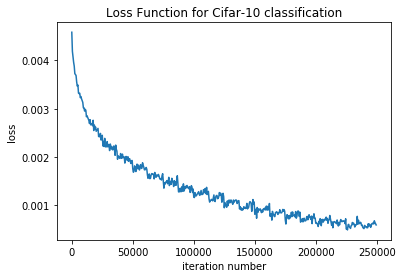

In [16]:
plt.plot([i*500 for i in range(len(losses))], [l/500 for l in  losses])
plt.ylabel("loss")
plt.xlabel("iteration number")
plt.title("Loss Function for Cifar-10 classification")
plt.savefig(folder + 'loss_plot.png')
plt.show()


In [19]:
model = ResNet(BasicBlock, [1,1,1,1], dropout=.2)   #(width=(1,1,1))
model.load_state_dict(torch.load(folder + 
                                 'saved_network.pt', map_location='cpu')['model_state_dict'])
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer2): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): R

In [20]:
def show_weights(w):
    if w.shape[1] == 3:
        fig, axes = plt.subplots(int(w.shape[0]/8), 8, figsize=(8, 8))
        for i in range(w.shape[0]):
            im = np.zeros((w.shape[2], w.shape[3], 3))
            im[:, :, 0] = w[i, 0, :, :] 
            im[:, :, 1] = w[i, 1, :, :] 
            im[:, :, 2] = w[i, 2, :, :]
            axes[int(i/8), i % 8].imshow(im)
            axes[int(i/8), i % 8].tick_params(labelbottom=False, labelleft=False, \
                                              bottom=False, left=False)
        plt.savefig(folder + 'filter_plots.png')
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

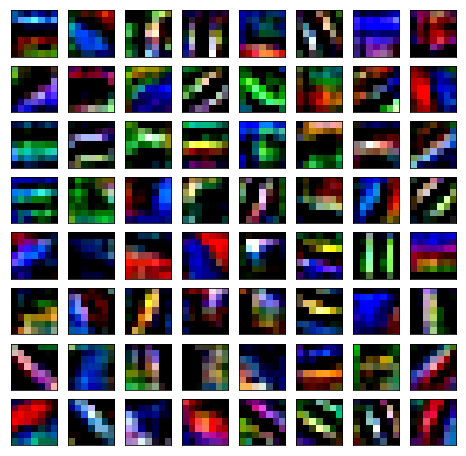

In [21]:
for m in model.modules():
    if isinstance(m, nn.Conv2d):
        show_weights(m.weight.data.numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


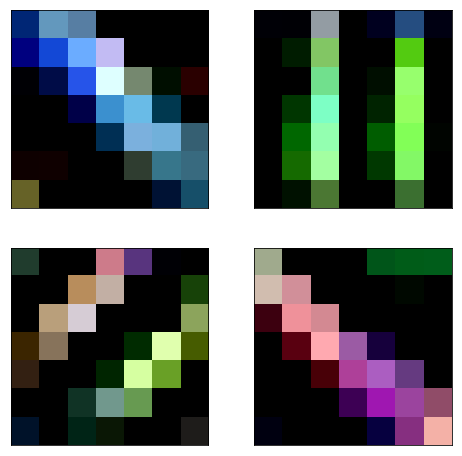

In [22]:
for m in model.modules():
    if isinstance(m, nn.Conv2d):
        w = m.weight.data.numpy()
        break

def get_im(i, w):
    im = np.zeros((w.shape[2], w.shape[3], 3))
    im[:, :, 0] = w[i, 0, :, :] 
    im[:, :, 1] = w[i, 1, :, :] 
    im[:, :, 2] = w[i, 2, :, :]
    return im
def add_im(axes, i, w, a, b):
    im = get_im(i, w)
    axes[a, b].imshow(im)
    axes[a, b].tick_params(labelbottom=False, labelleft=False, \
                                  bottom=False, left=False)

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
add_im(axes, 48, w, 1, 1)
add_im(axes, 57, w, 0, 0)
add_im(axes, 38, w, 0, 1)
add_im(axes, 31, w, 1, 0)
plt.savefig(folder + 'interesting_filters.png')



CAM Visualization

In [25]:
import io
import requests
from PIL import Image
from torchvision import models, transforms
from torch.autograd import Variable
from torch.nn import functional as F
import numpy as np
import cv2
import pdb

In [67]:
# input image
#LABELS_URL = 'https://s3.amazonaws.com/outcome-blog/imagenet/labels.json'
IMG_URL = 'https://www.popsci.com/sites/popsci.com/files/styles/655_1x_/public/images/2019/03/196428_web.jpg?itok=WoyINey8'
IMG_URL = 'https://static01.nyt.com/images/2019/01/22/upshot/22up-traffic1/merlin_144908511_f611b394-7ae4-4e80-a860-9442f5b88656-articleLarge.jpg'
#IMG_URL = 'https://www.thisiscolossal.com/wp-content/uploads/2018/03/bird-1.jpg'
#IMG_URL = 'https://ak7.picdn.net/shutterstock/videos/11333087/thumb/1.jpg'
#IMG_URL = 'http://www.rogz.com/wp-content/uploads/2015/08/Collection-of-Dogs-wb1.jpg'
#IMG_URL = 'http://www.kplctv.com/resizer/Cjvams3VR66VVSOLoAUUMWkib10=/1200x600/arc-anglerfish-arc2-prod-raycom.s3.amazonaws.com/public/ESML7FA2LVHXXD4SGBKARRWDXQ.jpg'
#IMG_URL = 'https://sowegalive.com/wp-content/uploads/2015/09/deer-crossing-road.jpg'
#IMG_URL = 'https://images.fineartamerica.com/images/artworkimages/mediumlarge/2/white-tail-deer-crossing-road-marvin-e-newman.jpg'
# IMG_URL = 'http://earthporm.com/wp-content/uploads/2015/06/frog-photography-20__880.jpg'
classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# networks such as googlenet, resnet, densenet already use global average pooling at the end, so CAM could be used directly.
net = model
finalconv_name = 'layer4'

net.eval()

# hook the feature extractor
features_blobs = []
def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())

net._modules.get(finalconv_name).register_forward_hook(hook_feature)

# get the softmax weight
params = list(net.parameters())
weight_softmax = np.squeeze(params[-2].data.numpy())


#I added
# ws = weight_softmax[:, ::2]
#print(weight_softmax.shape, ws.shape)
def returnCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 256x256
    print(feature_conv.shape)
    print(weight_softmax.shape)
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        cam = weight_softmax[idx].dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
preprocess = transform
    
# normalize = transforms.Normalize(
#    mean=[0.485, 0.456, 0.406],
#    std=[0.229, 0.224, 0.225]
# )
# preprocess = transforms.Compose([
#    transforms.Resize((224,224)),
#    transforms.ToTensor(),
#    normalize
# ])

response = requests.get(IMG_URL)
img_pil = Image.open(io.BytesIO(response.content))
img_pil.save('test.jpg')

img_tensor = preprocess(img_pil)
img_variable = Variable(img_tensor.unsqueeze(0))
logit = net(img_variable)

# download the imagenet category list
classes = {i: classes[i] for i in range(len(classes))}

h_x = F.softmax(logit, dim=1).data.squeeze()
probs, idx = h_x.sort(0, True)
probs = probs.numpy()
idx = idx.numpy()

# output the prediction
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))

# generate class activation mapping for the top1 prediction
CAMs = returnCAM(features_blobs[0], weight_softmax, idx)

# render the CAM and output
print('output CAM.jpg for the top1 prediction: %s'%classes[idx[0]])
img = cv2.imread('test.jpg')
height, width, _ = img.shape
heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
heatmap = heatmap[:,:,::-1]
result = heatmap * 0.4 + img * 0.5
cv2.imwrite('CAM.jpg', result)

0.996 -> bird
0.002 -> plane
0.001 -> cat
0.001 -> dog
0.000 -> deer
(1, 512, 11, 19)
(10, 512)
output CAM.jpg for the top1 prediction: bird


True

plane


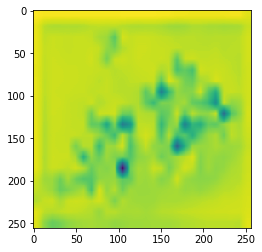

car


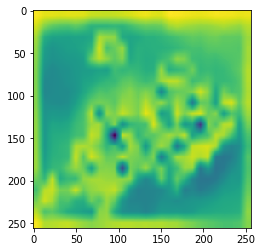

bird


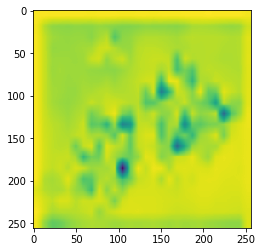

cat


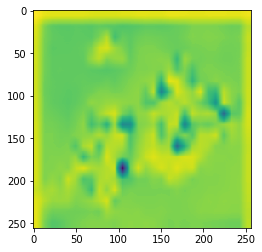

deer


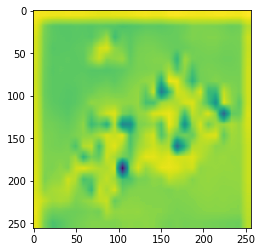

dog


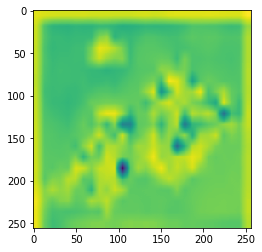

frog


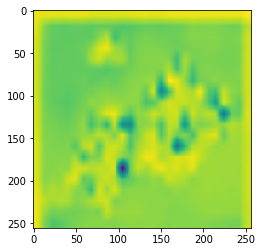

horse


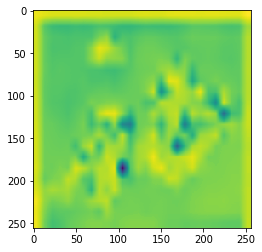

ship


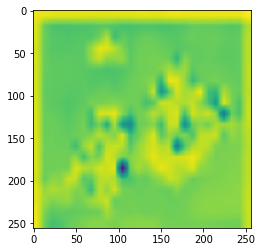

truck


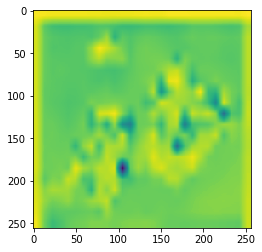

In [47]:
for i in range(len(CAMs)):
    print(classes[i])
    plt.imshow(CAMs[i])
    plt.show()